In [2]:
import os
import gc
import pywt
# import cupy
import optuna
import cv2 as cv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from zipfile import ZipFile
from tqdm import tqdm
from joblib import dump, load
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from xgboost import XGBRFClassifier, XGBClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import StratifiedKFold

import warnings
warnings.filterwarnings('ignore')

!pip install optuna_integration
from optuna_integration import XGBoostPruningCallback

In [3]:
with ZipFile('/kaggle/input/dogs-vs-cats/train.zip','r') as train:
    train.extractall('.')

Saving all the filenames and encoding dog as 1 and cat as 0

In [5]:
filenames = os.listdir('train')
pet_labels = []

for file in filenames:
    if file.split('.')[0] == 'cat':
        pet_labels.append(0)
    else:
        pet_labels.append(1)
        
label_df = pd.DataFrame()
label_df['filenames'] = filenames
label_df['labels'] = pet_labels
label_df.sample(5)

,filenames,labels
4772,cat.3042.jpg,0
14508,dog.11804.jpg,1
24142,dog.9226.jpg,1
21027,dog.6422.jpg,1
13658,dog.11039.jpg,1


In [4]:
def resize(img, target_height=300, target_width=300):
    '''
    Function for maintaining aspect ratio without any distortions while downscaling the images.
    The empty areas will be padded with black borders.
    '''

    height, width = img.shape[:2]

    if height > width:
        new_height = target_height
        new_width = int((width * target_height) / height)
    elif width > height:
        new_width = target_width
        new_height = int((height * target_width) / width)
    else:
        new_height = target_height
        new_width = target_width

    img_resize = cv.resize(img, (new_width, new_height), 
                           interpolation=cv.INTER_LANCZOS4)

    top = bottom = left = right = 0
    
    if new_height < target_height:
        padding_height = target_height - new_height
        top = int(padding_height / 2)
        bottom = padding_height - top
    if new_width < target_width:
        padding_width = target_width - new_width
        left = int(padding_width / 2)
        right = padding_width - left

    img_resize = cv.copyMakeBorder(img_resize, top, bottom, left, right, 
                                   cv.BORDER_CONSTANT, value=(0, 0, 0))
    
    return img_resize

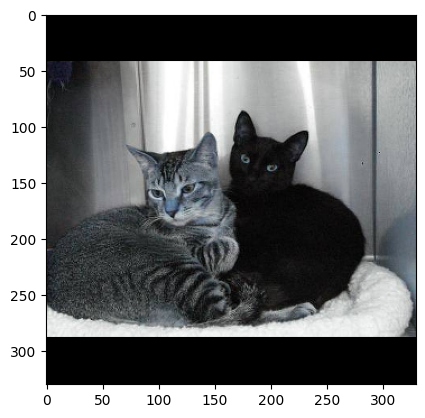

In [5]:
# Example
path = '/kaggle/working/train/cat.8.jpg'
img_src = cv.imread(path)
img = resize(img_src, 330, 330)
plt.imshow(img)
plt.show()

In [6]:
# Downscaling all the images to 15x15 and flattening it
train_path = '/kaggle/working/train/'
num_images = len(label_df)
img_resized = np.empty((num_images, 15*15*3))

for i,file in tqdm(enumerate(label_df['filenames']), total=num_images):
    file_path = train_path + file
    
    img_src = cv.imread(file_path)
    img_resized[i] = resize(img_src, 15, 15).flatten()

100%|██████████| 25000/25000 [00:46<00:00, 532.90it/s]


#### Feature Extraction

In [7]:
# Using wavelet decomposition to extract components from the images like edges, textures and other patterns. 
# Removing low frequency data from it and reconstructing back the image.
img_wavelet = np.empty((num_images, 16*16))

for i,file in tqdm(enumerate(label_df['filenames']), total=num_images):
    
    gc.collect()
    file_path = train_path + file
    img_src = cv.imread(file_path)
    img = cv.cvtColor(img_src, cv.COLOR_RGB2GRAY)
    img = resize(img, 16, 16)
    img = np.float32(img) / 255
    coef = pywt.wavedec2(img, 'db30', level=5)
    # Removing low frequency data (approximation coefficients) from the image
    coef[0] *= 0
    img = pywt.waverec2(coef, 'db30') * 255
    img_wavelet[i] = np.uint8(img).flatten()

100%|██████████| 25000/25000 [41:55<00:00,  9.94it/s] 


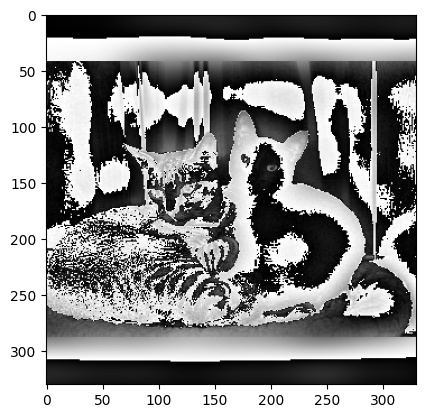

In [8]:
# Example image
path = '/kaggle/working/train/cat.8.jpg'
img_src = cv.imread(path)
img = cv.cvtColor(img_src, cv.COLOR_RGB2GRAY)
img = resize(img, 330, 330)
img = np.float32(img) / 255
coef = pywt.wavedec2(img, 'db30', level=5)
coef[0] *= 0
img = pywt.waverec2(coef, 'db30') * 255
img = np.uint8(img)
plt.imshow(img, cmap='gray')

For every image we'll stack together the downscaled image array and the wavelet transformed image array together. The resultant array will be used for training.

In [9]:
img_wavelet.shape, img_resized.shape

((25000, 256), (25000, 675))

In [10]:
# Stacking both the arrays together
img_data = np.hstack((img_resized,img_wavelet))
y = label_df['labels'].values
img_data.shape

(25000, 931)

#### Model Training

In [11]:
# Train test split using stratify
X_train, X_test, y_train, y_test = train_test_split(img_data, y, train_size=0.80, random_state=300, stratify=y)

# Saving the files
np.savez('train_test.npz', X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((20000, 931), (5000, 931), (20000,), (5000,))

In [12]:
# train_test = np.load('/kaggle/working/train_test.npz')
# X_train = train_test['X_train']
# X_test = train_test['X_test']
# y_train = train_test['y_train']
# y_test = train_test['y_test']

In [13]:
# The final array is in 0-255 range so standardizing it
scaler = StandardScaler()
X_train_stzd = scaler.fit_transform(X_train)
X_test_stzd = scaler.transform(X_test)

In [14]:
# For using GPU during training
X_train_stzd_gpu = cupy.array(X_train_stzd)
X_test_stzd_gpu = cupy.array(X_test_stzd)

In [14]:
# RandomForest from XGBoost
xgrf = XGBRFClassifier(device='cuda',tree_method='hist')
xgrf.fit(X_train_stzd_gpu, y_train)

y_pred_xgrf = xgrf.predict(X_test_stzd_gpu)
report_xgrf = classification_report(y_test,y_pred_xgrf)
print(f'Classififcation Report (XGRF):\n {report_xgrf}')

Classififcation Report (XGRF):
               precision    recall  f1-score   support

           0       0.63      0.62      0.62      2500
           1       0.63      0.64      0.63      2500

    accuracy                           0.63      5000
   macro avg       0.63      0.63      0.63      5000
weighted avg       0.63      0.63      0.63      5000



In [20]:
# For SVC, applying PCA first since training takes long time with SVC for high dimensional data
# Choosing num of components that make up 99% of explained variance
pca = PCA(n_components=0.99)
X_train_pca = pca.fit_transform(X_train_stzd)
X_test_pca = pca.transform(X_test_stzd)

sv = SVC()
sv.fit(X_train_pca,y_train)

y_test_pred_sv = sv.predict(X_test_pca)
report_sv = classification_report(y_test,y_test_pred_sv)
print(f'Classififcation Report (SVC):\n {report_sv}')

Classififcation Report (SVC):
               precision    recall  f1-score   support

           0       0.67      0.67      0.67      2500
           1       0.67      0.67      0.67      2500

    accuracy                           0.67      5000
   macro avg       0.67      0.67      0.67      5000
weighted avg       0.67      0.67      0.67      5000



In [15]:
# XGBoost Classifier model
xgbc = XGBClassifier(device='cuda',tree_method='hist')
xgbc.fit(X_train_stzd_gpu,y_train)

y_test_pred_xgbc = xgbc.predict(X_test_stzd_gpu)
report_xgbc = classification_report(y_test,y_test_pred_xgbc)
print(f'Classififcation Report (XGBClassifier):\n {report_xgbc}')

Classififcation Report (XGBClassifier):
               precision    recall  f1-score   support

           0       0.66      0.67      0.67      2500
           1       0.67      0.66      0.66      2500

    accuracy                           0.66      5000
   macro avg       0.66      0.66      0.66      5000
weighted avg       0.66      0.66      0.66      5000



#### Hyperparameter Tuning

Hyperparameter tuning XGboost Classifier model with Optuna

In [18]:
# Making a validation set for tuning
X_train_xg, X_val_xg, y_train_xg, y_val_xg = train_test_split(X_train_stzd, y_train, test_size=0.20, 
                                                              random_state=300, stratify=y_train)

# Storing both train and test in gpu
X_train_xg_gpu = cupy.array(X_train_xg)
X_val_xg_gpu = cupy.array(X_val_xg)

In [16]:
def objective(trial):
    
    pruning_callback = XGBoostPruningCallback(trial, 'validation_0-error')
    
    xgb_tuning=XGBClassifier(
        n_estimators=trial.suggest_int('n_estimators', 50, 10000),
        max_depth=trial.suggest_int('max_depth', 2, 70),
        min_child_weight=trial.suggest_int('min_child_weight', 1, 20),
        colsample_bytree=trial.suggest_float('colsample_bytree', 0.2, 1),
        subsample=trial.suggest_float('subsample', 0.2, 1),
        learning_rate=trial.suggest_float('learning_rate', 1e-4, 1, log=True),
        reg_alpha=trial.suggest_float('reg_alpha',1e-2, 100, log=True),
        reg_lambda=trial.suggest_float('reg_lambda',1e-2, 100, log=True),
        objective='binary:logistic',
        callbacks=[pruning_callback],
        eval_metric='error',
        device='cuda',
        tree_method='hist',
        n_jobs=-1
    )
    
    gc.collect()
    xgb_tuning.fit(X_train_xg_gpu, y_train_xg,
                   eval_set=[(X_val_xg_gpu, y_val_xg)], 
                   verbose=False)
    
    y_val_xg_pred = xgb_tuning.predict(X_val_xg_gpu)
    accuracy = accuracy_score(y_val_xg, y_val_xg_pred)
    
    return accuracy
    
study = optuna.create_study(direction='maximize',
                            pruner=optuna.pruners.MedianPruner(n_warmup_steps=5),
                            study_name='XGBClassifier Image Classification Tuning')

# Will run for 150 trials or 3 hours, whichever happens first
study.optimize(objective, n_trials=150, timeout=3*60*60)
dump(study,'XGBClassifier_image_classifier_study.pkl')

best_params = study.best_trial.params

[I 2024-05-03 01:30:34,654] A new study created in memory with name: XGBClassifier Image Classification Tuning
[I 2024-05-03 01:32:28,973] Trial 0 finished with value: 0.62375 and parameters: {'n_estimators': 7902, 'max_depth': 21, 'min_child_weight': 18, 'colsample_bytree': 0.9822313152085935, 'subsample': 0.49796126675610664, 'learning_rate': 0.0002140874215941077, 'reg_alpha': 1.7241433251830236, 'reg_lambda': 73.89872494237888}. Best is trial 0 with value: 0.62375.
[I 2024-05-03 01:33:20,322] Trial 1 finished with value: 0.64 and parameters: {'n_estimators': 5659, 'max_depth': 47, 'min_child_weight': 4, 'colsample_bytree': 0.3450624251013055, 'subsample': 0.8099447128659214, 'learning_rate': 0.6605302524237124, 'reg_alpha': 1.304229582927169, 'reg_lambda': 0.3013917460031855}. Best is trial 1 with value: 0.64.
[I 2024-05-03 01:34:42,661] Trial 2 finished with value: 0.66475 and parameters: {'n_estimators': 9030, 'max_depth': 26, 'min_child_weight': 8, 'colsample_bytree': 0.56216803

In [24]:
print('--'*45)
print('The best Hyperparameters are: ')
for key,value in best_params.items():
    print(f'{key:>30s} : {value}')
print('--'*45)
print(f'{"Best Accuracy (Val Set)":>30s} : {study.best_value}')
print('=='*45)

------------------------------------------------------------------------------------------
The best Hyperparameters are: 
                  n_estimators : 9617
                     max_depth : 9
              min_child_weight : 16
              colsample_bytree : 0.5194946862466436
                     subsample : 0.6583869152770417
                 learning_rate : 0.013391113538835268
                     reg_alpha : 0.11034111069880503
                    reg_lambda : 0.17351802885086906
------------------------------------------------------------------------------------------
       Best Accuracy (Val Set) : 0.70125


In [25]:
# Eval metrics for test set
xgbc = XGBClassifier(device='cuda', tree_method='hist', **best_params)
xgbc.fit(X_train_stzd_gpu,y_train)

y_test_pred_xgbc = xgbc.predict(X_test_stzd_gpu)
report_xgbc = classification_report(y_test,y_test_pred_xgbc)
print(f'Classififcation Report For Test Set (Tuned XGBClassifier Model):\n {report_xgbc}')

Classififcation Report For Test Set (Tuned XGBClassifier Model):
               precision    recall  f1-score   support

           0       0.71      0.73      0.72      2500
           1       0.72      0.70      0.71      2500

    accuracy                           0.71      5000
   macro avg       0.71      0.71      0.71      5000
weighted avg       0.71      0.71      0.71      5000



Best accuracy on test set is 71%

#### Predicting Kaggle Test Set

In [21]:
with ZipFile('/kaggle/input/dogs-vs-cats/test1.zip','r') as test:
    test.extractall('.')

In [22]:
id = []
image_paths = []

for file in os.listdir('test1'):
    id.append(int(file.split('.')[0]))
    image_paths.append('/kaggle/working/test1/' + file)

In [23]:
Submission = pd.DataFrame()
Submission['id'] = id
Submission['image_paths'] = image_paths
Submission.sample(5)

,id,image_paths
1796,2258,/kaggle/working/test1/2258.jpg
441,3924,/kaggle/working/test1/3924.jpg
4477,1428,/kaggle/working/test1/1428.jpg
7209,9880,/kaggle/working/test1/9880.jpg
3630,2053,/kaggle/working/test1/2053.jpg


In [24]:
def test_preprocessor(image_paths, scaler):
    '''
    For applying all the preprocessing steps we had done for training
    on the kaggle test data as well. Returns test image array.
    '''
    
    num_images = len(image_paths)
    img_resized = np.empty((num_images, 15*15*3))
    img_wavelet = np.empty((num_images, 16*16))
    
    for i,image_path in tqdm(enumerate(image_paths), total=num_images):
        # Downscaling
        img_src = cv.imread(image_path)
        img_resized[i] = resize(img_src, 15, 15).flatten()
        # Wavelet Decompose
        img = cv.cvtColor(img_src, cv.COLOR_RGB2GRAY)
        img = resize(img, 16, 16)
        img = np.float32(img) / 255
        coef = pywt.wavedec2(img, 'db30', level=5)
        coef[0] *= 0
        img = pywt.waverec2(coef, 'db30') * 255
        img_wavelet[i] = np.uint8(img).flatten()
    # Concatenating
    img_data = np.hstack((img_resized,img_wavelet))
    # scaler transform
    test_preprocessed = scaler.transform(img_data)
    
    return test_preprocessed

In [25]:
test_array = test_preprocessor(Submission['image_paths'], scaler)
test_array[:3]

100%|██████████| 12500/12500 [02:09<00:00, 96.79it/s] 


array([[-0.3073806 , -0.31793717, -0.32121417, ...,  0.18275878,
         0.09262296,  0.03889465],
       [-0.3073806 , -0.31793717, -0.32121417, ...,  0.27861263,
         0.21508342,  0.19021361],
       [-0.3073806 , -0.31793717, -0.32121417, ..., -0.41153508,
        -0.69112393, -1.2473165 ]])

label
1    6351
0    6149
Name: count, dtype: int64


<Axes: xlabel='label'>

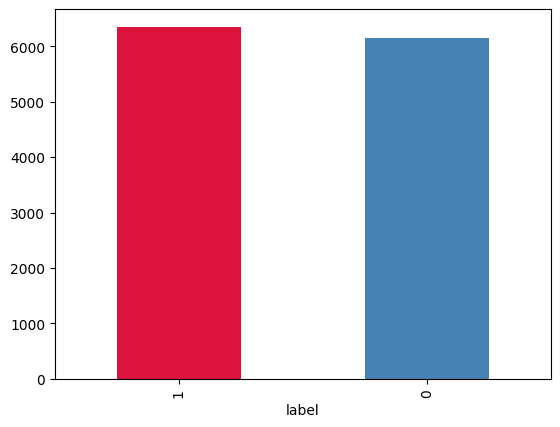

In [26]:
# Kaggle test set predictions
labels = xgbc.predict(test_array)

# Saving to dataframe
Submission['label'] = labels


print(Submission['label'].value_counts())
Submission['label'].value_counts().plot(kind='bar', color=['crimson','steelblue'])

In [28]:
Submission[['id','label']].sort_values('id',ascending=True).to_csv('submission.csv',index=False)